In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import pickle
from fair_loss import FairLoss
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import BinaryFairness
from fairlearn.metrics import demographic_parity_ratio,  demographic_parity_difference
from sklearn.metrics import f1_score, balanced_accuracy_score,recall_score
import matplotlib.pyplot as plt
# from datasets import ADULT, German, Lawschool, HealthHeritage
# from defenses import dp_defense

ModuleNotFoundError: No module named 'torchmetrics'

In [63]:
import torch
print(torch.__version__)


2.3.0


In [64]:
class LinReLU(nn.Module):

    """
    A linear layer followed by a ReLU activation layer.
    """    
        
    def __init__(self, in_size, out_size):
        super(LinReLU, self).__init__()      
        linear = nn.Linear(in_size, out_size)
        ReLU = nn.ReLU()
        # self.Dropout = nn.Dropout(0.25)
        self.layers = nn.Sequential(linear, ReLU)

    def reset_parameters(self):
        self.layers[0].reset_parameters()
        return self

    def forward(self, x):
        x = self.layers(x)
        return x

class FullyConnected(nn.Module):
    """
    A simple fully connected neural network with ReLU activations.
    """
    def __init__(self, input_size, layout):

        super(FullyConnected, self).__init__()
        layers = [nn.Flatten()]  # does not play any role, but makes the code neater
        prev_fc_size = input_size
        for i, fc_size in enumerate(layout):
            if i + 1 < len(layout):
                layers += [LinReLU(prev_fc_size, fc_size)]
            else:
                layers += [nn.Linear(prev_fc_size, 1), nn.Sigmoid()]
                # layers += [nn.Linear(prev_fc_size, fc_size)]
            prev_fc_size = fc_size
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

In [65]:
client_data_dir='50_clients_data_testing/client_subG_processed/'

layout = [100, 100, 2]
batch_size = 32
num_epochs = 5  
input_dim = 10

model = FullyConnected(input_dim, layout)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01) 

In [66]:
client_models = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
               "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
               "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
               "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
               "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# client_models = ["AL","AK", "AZ"]

# testing_data=["WM","WW","BM","BW"]
testing_data=["male","female","white","black"]

# Normal Testing

In [6]:
# 0 male
# 1 female
# 1 white
# 2 black

In [7]:

# model.load_state_dict(torch.load(f'../{exp_1}/50_clients_data/clients_trained_model/{model_name}.pth'))
# model.load_state_dict(torch.load(f'50_clients_data/client_DP_trained_model/{model_name}.pth'))
# model.load_state_dict(torch.load(f'50_clients_data/clients_fair_trained_model/{model_name}.pth'))
# model.load_state_dict(torch.load(f'50_clients_data/clients_DP_Fair_trained_model/{model_name}.pth'))

In [8]:
#  tensor(1.0448) convert to 1 ------Female
#  tensor(-0.9571) convert to 0----Male

In [9]:
exp_1="tableak_FT_inversion_normal"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_1}/50_clients_data/clients_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
male
Total length of male test data: 86936
0.49045136943870843 : 0.7532207600993834 : 0.7647329751069197 : 0.7530817720890413 : 0.7553235275003791
female
Total length of female test data: 79835
0.5149432873678111 : 0.7146364376526586 : 0.7640882261571919 : 0.7392006793367599 : 0.6732973209723337
white
Total length of white test data: 130463
0.48254913952030737 : 0.7562757256846769 : 0.778583216695565 : 0.7610811504538157 : 0.7327478864932171
black
Total length of black test data: 14480
0.5337261240477067 : 0.6982044198895028 : 0.75904278782532 : 0.7391522958480372 : 0.6504441504441505
model_name AK
male
Total length of male test data: 86936
0.49023971747487705 : 0.7478719977914788 : 0.7377451273645294 : 0.7531612068899871 : 0.6678508762428785
female
Total length of female test data: 79835
0.5693534394782148 : 0.673413916202167 : 0.7078950021846536 : 0.7309677460137147 : 0.5765566829695599
white
Total length of white test data: 130463
0.5017685205701932 : 0.737504119942052

In [10]:
final_result

{'AL': {'male': 0.7553235275003791,
  'female': 0.6732973209723337,
  'white': 0.7327478864932171,
  'black': 0.6504441504441505},
 'AK': {'male': 0.6678508762428785,
  'female': 0.5765566829695599,
  'white': 0.6430827708237762,
  'black': 0.5651105651105651},
 'AZ': {'male': 0.7309100361761584,
  'female': 0.6463062997299073,
  'white': 0.704856150468576,
  'black': 0.6233226233226233},
 'AR': {'male': 0.7753828823949916,
  'female': 0.6963464486458866,
  'white': 0.7521462743299037,
  'black': 0.6674541674541674},
 'CA': {'male': 0.6804583757554752,
  'female': 0.5911745382874662,
  'white': 0.6539353823972738,
  'black': 0.5766395766395767},
 'CO': {'male': 0.6892749604661742,
  'female': 0.5998248047302723,
  'white': 0.6630709745068484,
  'black': 0.5854280854280854},
 'CT': {'male': 0.6644498841063189,
  'female': 0.571702314037521,
  'white': 0.6366341175699587,
  'black': 0.5608580608580609},
 'DE': {'male': 0.7123237224617117,
  'female': 0.6249361267245784,
  'white': 0.6866

In [11]:

filename = "inversion_group_normal_fairness.pickle"
# filename = "inversion_subgroup_normal_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_group_normal_fairness.pickle


# Dp testing

In [12]:
exp_2="tableak_FT_inversion_DP"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_2}/50_clients_data/client_DP_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
male
Total length of male test data: 86936
0.4907182454185359 : 0.7530597220944143 : 0.7648682394690148 : 0.7528399300781636 : 0.7563849836449105
female
Total length of female test data: 79835
0.5146676182985783 : 0.7148994801778669 : 0.7643422891753378 : 0.7394248314479183 : 0.6736258121030733
white
Total length of white test data: 130463
0.4830592105150047 : 0.7564980109303021 : 0.7790052173913042 : 0.761118611367591 : 0.7338750901107544
black
Total length of black test data: 14480
0.5325581889278841 : 0.6990331491712707 : 0.7600220264317181 : 0.7392331712495899 : 0.6521451521451521
model_name AK
male
Total length of male test data: 86936
0.49124420071990776 : 0.7470898131959143 : 0.7358189049226814 : 0.752628006450219 : 0.6633017784806013
female
Total length of female test data: 79835
0.5726364035166815 : 0.671034007640759 : 0.7043753306543297 : 0.7304811137446228 : 0.5709905832542521
white
Total length of white test data: 130463
0.5036849228627313 : 0.7365229988579137

In [13]:
final_result

{'AL': {'male': 0.7563849836449105,
  'female': 0.6736258121030733,
  'white': 0.7338750901107544,
  'black': 0.6521451521451521},
 'AK': {'male': 0.6633017784806013,
  'female': 0.5709905832542521,
  'white': 0.6391768792188217,
  'black': 0.561992061992062},
 'AZ': {'male': 0.7293070207742132,
  'female': 0.6423644061610336,
  'white': 0.7016711448980929,
  'black': 0.6234171234171234},
 'AR': {'male': 0.7789355111236271,
  'female': 0.6996678589678079,
  'white': 0.7543744675273609,
  'black': 0.6712341712341713},
 'CA': {'male': 0.6810432597534822,
  'female': 0.5906818015913571,
  'white': 0.6546431614129367,
  'black': 0.5768285768285768},
 'CO': {'male': 0.6873686718800771,
  'female': 0.5971421271625666,
  'white': 0.6608165672717741,
  'black': 0.5841995841995842},
 'CT': {'male': 0.6650347681043259,
  'female': 0.5722680487626834,
  'white': 0.6377088931122616,
  'black': 0.5607635607635607},
 'DE': {'male': 0.710547408097394,
  'female': 0.6222534491568728,
  'white': 0.6847

In [14]:

filename = "inversion_group_dp_fairness.pickle"
# filename = "inversion_subgroup_dp_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_group_dp_fairness.pickle


# Fair testing

In [15]:
exp_3="tableak_FT_inversion_fair"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_3}/50_clients_data/clients_fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
male
Total length of male test data: 86936
0.49092963408098794 : 0.7543365234195271 : 0.7669543773119606 : 0.7538775309445085 : 0.7612806793319326
female
Total length of female test data: 79835
0.5127770388651945 : 0.7211122941065948 : 0.7700823015520607 : 0.7452628447399268 : 0.6804693773268122
white
Total length of white test data: 130463
0.4848539160913131 : 0.758260962878364 : 0.7806448920543068 : 0.7628989758571172 : 0.7355527885182516
black
Total length of black test data: 14480
0.5336174930694614 : 0.6975138121546961 : 0.758198078834051 : 0.7391659205409846 : 0.6489321489321489
model_name AK
male
Total length of male test data: 86936
0.49365145390332954 : 0.7454564277169412 : 0.7314409155450916 : 0.751581096550417 : 0.6527955288867708
female
Total length of female test data: 79835
0.5761402771085918 : 0.6657606313020605 : 0.6969862142581362 : 0.7285698413693851 : 0.5600591284035331
white
Total length of white test data: 130463
0.5084804468348473 : 0.732368564267263

In [16]:
final_result

{'AL': {'male': 0.7612806793319326,
  'female': 0.6804693773268122,
  'white': 0.7355527885182516,
  'black': 0.6489321489321489},
 'AK': {'male': 0.6527955288867708,
  'female': 0.5600591284035331,
  'white': 0.6278524149682155,
  'black': 0.5498015498015498},
 'AZ': {'male': 0.7252778198990534,
  'female': 0.6377107818088912,
  'white': 0.7004521921488958,
  'black': 0.6152901152901152},
 'AR': {'male': 0.7461386824946385,
  'female': 0.6659062705306956,
  'white': 0.7193131922144308,
  'black': 0.635985635985636},
 'CA': {'male': 0.6553083638411715,
  'female': 0.5637272793634572,
  'white': 0.6257552919588439,
  'black': 0.5461160461160461},
 'CO': {'male': 0.6623269718172562,
  'female': 0.5704430980363531,
  'white': 0.6333311488301986,
  'black': 0.5601020601020601},
 'CT': {'male': 0.6258258778675563,
  'female': 0.5327943645521571,
  'white': 0.5945474801756341,
  'black': 0.5194670194670195},
 'DE': {'male': 0.7332712345384832,
  'female': 0.6488247317322432,
  'white': 0.707

In [17]:

filename = "inversion_group_fair_fairness.pickle"
# filename = "inversion_subgroup_fair_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_group_fair_fairness.pickle


# fairDP testing

In [18]:
exp_4="tableak_FT_inversion_fairDP"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_4}/50_clients_data/clients_DP_Fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
male
Total length of male test data: 86936
0.48947605965635027 : 0.7545550749976995 : 0.7648135085089498 : 0.7547519890270937 : 0.7515759374390746
female
Total length of female test data: 79835
0.515905728464375 : 0.7169912945449991 : 0.7646213147202833 : 0.745080265485893 : 0.6697204175487261
white
Total length of white test data: 130463
0.48512355176613614 : 0.7559308003035343 : 0.7764909029649596 : 0.7622559334352375 : 0.7249623173209253
black
Total length of black test data: 14480
0.539175313566431 : 0.6939917127071823 : 0.7538470084995279 : 0.7392678148193798 : 0.6411831411831412
model_name AK
male
Total length of male test data: 86936
0.4912830307547731 : 0.7485391552406367 : 0.7388016010514368 : 0.7537478924992975 : 0.6697355024586791
female
Total length of female test data: 79835
0.5663704840716475 : 0.6753178430512933 : 0.7101305033380674 : 0.7322896439959387 : 0.5794401051171618
white
Total length of white test data: 130463
0.5025081732473684 : 0.738669201229467

In [19]:
final_result

{'AL': {'male': 0.7515759374390746,
  'female': 0.6697204175487261,
  'white': 0.7249623173209253,
  'black': 0.6411831411831412},
 'AK': {'male': 0.6697355024586791,
  'female': 0.5794401051171618,
  'white': 0.6455993184350219,
  'black': 0.565961065961066},
 'AZ': {'male': 0.7157463769685679,
  'female': 0.6271443171034382,
  'white': 0.6906612490988925,
  'black': 0.609053109053109},
 'AR': {'male': 0.7640318003595954,
  'female': 0.6841375282867362,
  'white': 0.7344124778819058,
  'black': 0.6514836514836515},
 'CA': {'male': 0.6766024738426879,
  'female': 0.585571939557632,
  'white': 0.6495183170587849,
  'black': 0.570969570969571},
 'CO': {'male': 0.6939323700799341,
  'female': 0.6040586904153588,
  'white': 0.6674487187889114,
  'black': 0.5905310905310905},
 'CT': {'male': 0.6660962242488573,
  'female': 0.5741842470253303,
  'white': 0.6392817353692902,
  'black': 0.5582120582120582},
 'DE': {'male': 0.7209886705803349,
  'female': 0.6342433754288634,
  'white': 0.692561

In [20]:

filename = "inversion_group_fairDp_fairness.pickle"
# filename = "inversion_subgroup_fairDp_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_group_fairDp_fairness.pickle


In [67]:
subgrp_exp = False
group_exp = True


if subgrp_exp is True:
    print("Subgrp exp is selected")
    
    normal_train = "inversion_subgroup_normal_fairness.pickle"
    dp_train = "inversion_subgroup_dp_fairness.pickle"
    fair_train = "inversion_subgroup_fair_fairness.pickle"
    fairDP_train = "inversion_subgroup_fairDp_fairness.pickle"
    
if group_exp is True :
    print("group exp is selected")
    
    normal_train = "inversion_group_normal_fairness.pickle"
    dp_train = "inversion_group_dp_fairness.pickle"
    fair_train = "inversion_group_fair_fairness.pickle"
    fairDP_train = "inversion_group_fairDp_fairness.pickle"



with open(normal_train, 'rb') as file:
    normal_train_loaded = pickle.load(file)
with open(dp_train, 'rb') as file:
    dp_train_loaded = pickle.load(file)
with open(fair_train, 'rb') as file:
    fair_train_loaded = pickle.load(file)
with open(fairDP_train, 'rb') as file:
    fairDP_train_loaded = pickle.load(file)




group exp is selected


In [88]:
def subgroup_calculate_state_ratios(data):
    state_names = []
    ratios_list = []
    denominator_list = []
    
    for state, values in data.items():
        # Find maximum value and its key
        max_value = max(values, key=values.get)
        max_value_amount = values[max_value]
        
        # Calculate ratios
        ratios = {}
        for key, value in values.items():
            if key != max_value:  # Exclude the max_value itself
                ratios[key + '/' + max_value] = value / max_value_amount
        
        # Append state data
        state_names.append(state)
        denominator_list.append(max_value)
        ratios_list.append(ratios)
    
    # Create DataFrame with ratios
    df_final = pd.DataFrame(ratios_list).fillna("")
    
    # Add state column
    df_final.insert(0, 'State', state_names)
    
    # Reset index to make sure it's numeric
    df_final = df_final.reset_index(drop=True)
    
    return df_final

In [69]:
def compute_ratios(data_dict):
    results_fixed = []
    for state, values in data_dict.items():
        # female_to_male: ensure female is the numerator
        female_to_male = values['female'] / values['male'] if values['male'] != 0 else None

        # black_to_white: ensure black is the numerator
        black_to_white = values['black'] / values['white'] if values['white'] != 0 else None

        # Append each state's data as a dictionary
        results_fixed.append({
            'State': state,
            'Female_to_Male': female_to_male,
            'Black_to_White': black_to_white
        })
        
    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(results_fixed)

In [70]:
normal_train_df=compute_ratios(normal_train_loaded)
dp_train_df=compute_ratios(dp_train_loaded)
fair_train_df=compute_ratios(fair_train_loaded)
fairDP_train_df=compute_ratios(fairDP_train_loaded)

In [71]:
normal_train_df

,State,Female_to_Male,Black_to_White
0,AL,0.891403,0.887678
1,AK,0.863302,0.878752
2,AZ,0.884249,0.884326
3,AR,0.898068,0.887399
4,CA,0.868789,0.881799
5,CO,0.870226,0.882904
6,CT,0.860414,0.880974
7,DE,0.877320,0.885031
8,FL,0.886124,0.887002
9,GA,0.880593,0.883436


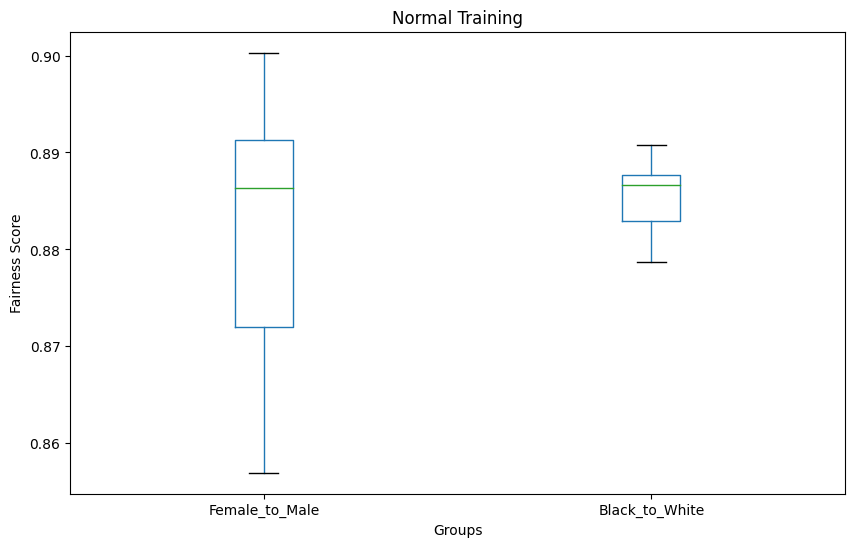

In [72]:
plt.figure(figsize=(10, 6))
normal_train_df.drop("State", axis=1).boxplot()
plt.title("Normal Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

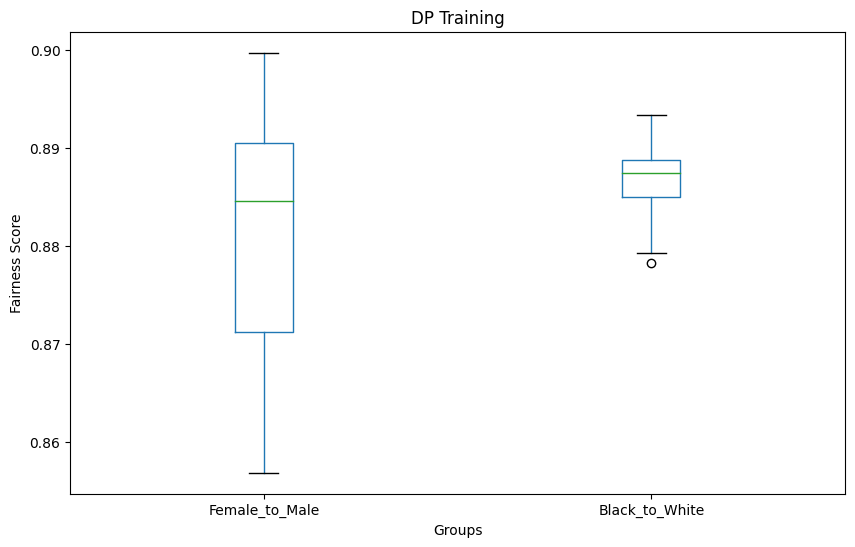

In [73]:
plt.figure(figsize=(10, 6))
dp_train_df.drop("State", axis=1).boxplot()
plt.title("DP Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

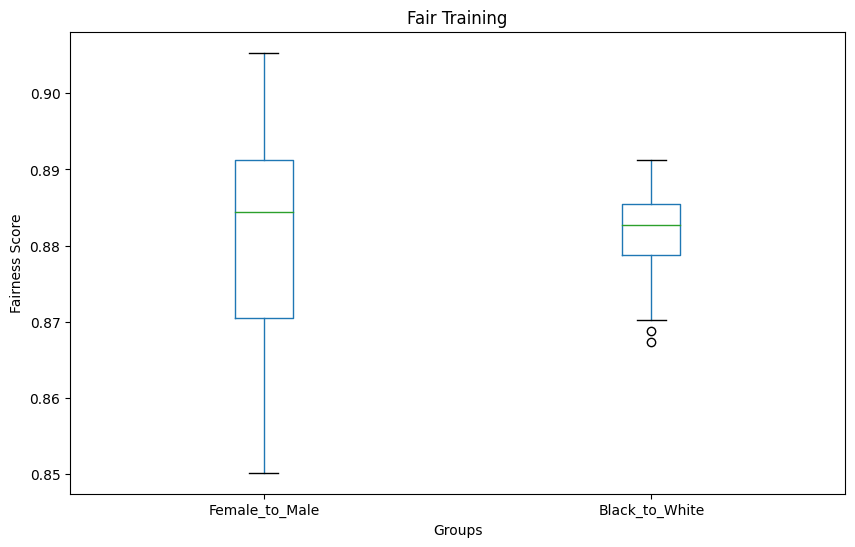

In [74]:
plt.figure(figsize=(10, 6))
fair_train_df.drop("State", axis=1).boxplot()
plt.title("Fair Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

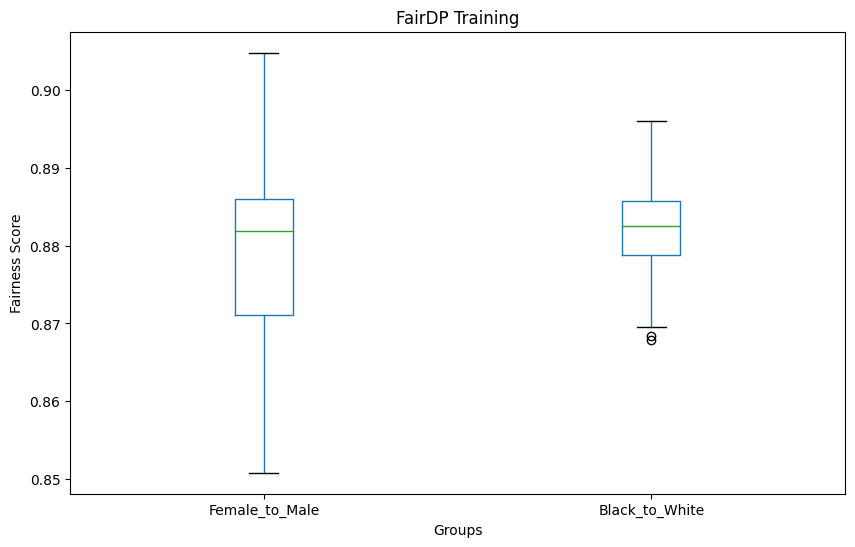

In [75]:
plt.figure(figsize=(10, 6))
fairDP_train_df.drop("State", axis=1).boxplot()
plt.title("FairDP Training")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

# fair - Grouploss

In [50]:
exp_3="tableak_FT_inversion_fair_group_loss"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_3}/50_clients_data/clients_fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
male
Total length of male test data: 86936
0.5064098439455296 : 0.7462731204564277 : 0.7749229607559031 : 0.7412305030385816 : 0.8225635249008947
female
Total length of female test data: 79835
0.48851555866564444 : 0.7426943070082044 : 0.8006211782975832 : 0.7367590870964851 : 0.7526826775677057
white
Total length of white test data: 130463
0.48297401413646784 : 0.7605987904616635 : 0.7966323520793859 : 0.7521845683456165 : 0.8017956615767744
black
Total length of black test data: 14480
0.4926755516471189 : 0.7328038674033149 : 0.7984370929929668 : 0.7402197493269838 : 0.7241542241542241
model_name AK
male
Total length of male test data: 86936
0.4860611547924027 : 0.7520934940645992 : 0.7474809017200168 : 0.7561325375762311 : 0.6909862877196022
female
Total length of female test data: 79835
0.5500642862969745 : 0.6871672825201979 : 0.7257332996562744 : 0.7371696040737512 : 0.6030184685013504
white
Total length of white test data: 130463
0.4913363370323462 : 0.746786445199

In [51]:
final_result

{'AL': {'male': 0.8225635249008947,
  'female': 0.7526826775677057,
  'white': 0.8017956615767744,
  'black': 0.7241542241542241},
 'AK': {'male': 0.6909862877196022,
  'female': 0.6030184685013504,
  'white': 0.6707516875286716,
  'black': 0.5887355887355887},
 'AZ': {'male': 0.7892034746441956,
  'female': 0.7099240820497846,
  'white': 0.7647683334425585,
  'black': 0.6821016821016821},
 'AR': {'male': 0.851157853692351,
  'female': 0.7900029199211621,
  'white': 0.8328855101907071,
  'black': 0.7547722547722547},
 'CA': {'male': 0.71466325845374,
  'female': 0.6249726257391051,
  'white': 0.6870830329641523,
  'black': 0.6068796068796068},
 'CO': {'male': 0.7258410415267639,
  'female': 0.6391159938681655,
  'white': 0.7002949079231928,
  'black': 0.6191646191646192},
 'CT': {'male': 0.6862638909949527,
  'female': 0.596868384553617,
  'white': 0.6615112392686283,
  'black': 0.5811755811755812},
 'DE': {'male': 0.7631436431774364,
  'female': 0.6784071830060588,
  'white': 0.735434

In [52]:

filename = "inversion_group_fair_fairness_groupLoss.pickle"
# filename = "inversion_subgroup_fair_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_group_fair_fairness_groupLoss.pickle


In [87]:
fair_train = "inversion_group_fair_fairness_groupLoss.pickle"
fair_train_sub="inversion_subgroup_fair_fairness.pickle"
with open(fair_train, 'rb') as file:
    fair_train_loaded = pickle.load(file)

with open(fair_train_sub, 'rb') as file:
    fair_train_loaded_sub = pickle.load(file)

In [89]:
fair_train_df=compute_ratios(fair_train_loaded)
fair_train_df_sub=subgroup_calculate_state_ratios(fair_train_loaded_sub)

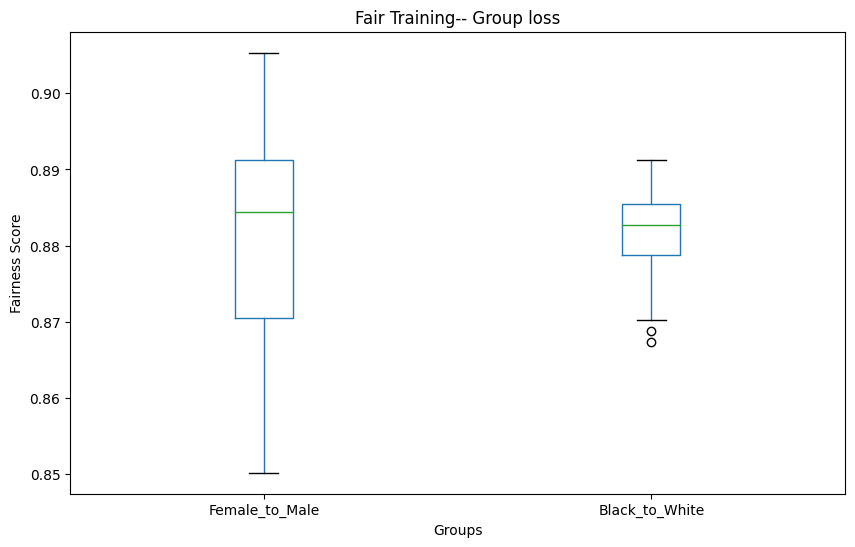

In [85]:
plt.figure(figsize=(10, 6))
fair_train_df.drop("State", axis=1).boxplot()
plt.title("Fair Training-- Group loss")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

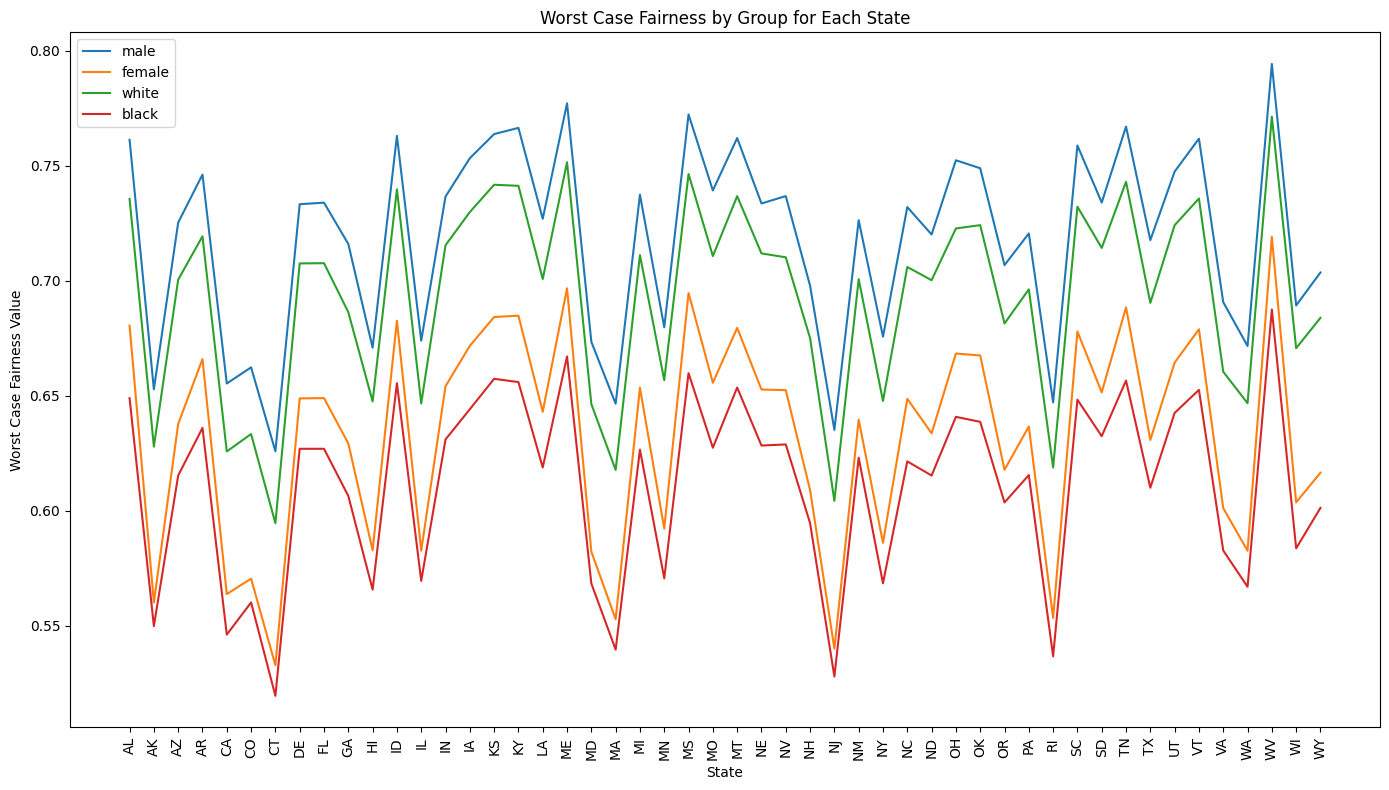

In [86]:
df = pd.DataFrame(fair_train_loaded).T
df.index.name = 'State'
df.reset_index(inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Colors and labels for each group
groups = ['male', 'female', 'white', 'black']
for group in groups:
    ax.plot(df['State'], df[group], label=group)

ax.set_title("Worst Case Fairness by Group for Each State")
ax.set_xlabel("State")
ax.set_ylabel("Worst Case Fairness Value")
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# fairDp - grouploss

In [56]:
exp_4="tableak_FT_inversion_fairDP_group_loss"
final_result={}

for model_name in client_models:
    temp_result={}
    print("model_name",model_name)
    model.load_state_dict(torch.load(f'../{exp_4}/50_clients_data/clients_DP_Fair_trained_model/{model_name}.pth'))
    for test_split in testing_data:
        print(test_split)
    
        with open(client_data_dir + f'{test_split}.pkl', 'rb') as f:
            test_data = pickle.load(f)
    
        total_length = sum(len(batch[0]) for batch in test_data)
        print(f'Total length of {test_split} test data: {total_length}')
        
        fairness_score = []
        fair_ratio = []
        parity_diff = []
        temp_out = []
        temp_lab = []
        temp_group = []
    
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
    
            threshold = 0.0
            all_labels = []
            all_predicted_classes = []
    
            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print("stopped earlier")
                #     break
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
    
                #=====================Need to check=====================#
    
                # groups = inputs[:, 8].long()
                # groups = (groups > threshold).long()
                # temp_group.append(groups)
                
                #======================================================#
    
                outputs = model(inputs)
                # temp_out.append(outputs)
    
                # metric = BinaryFairness(2)
                # temp_fairness_score = metric(outputs, labels, groups)
                # fairness_score.append(temp_fairness_score)
    
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()
    
                predicted_classes = (outputs > 0.5).float()
                temp_out.append(predicted_classes)
    
                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)
    
                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())
    
            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total
    
            all_labels = np.array(all_labels)
            all_predicted_classes = np.array(all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            balanced_acc = balanced_accuracy_score(all_labels, all_predicted_classes)
            tpr = recall_score(all_labels, all_predicted_classes)
            temp_result[test_split]= tpr
            print(val_epoch_loss, ":", val_accuracy, ":", f1, ":", balanced_acc, ":", tpr)
            final_result[model_name]=temp_result
            

model_name AL
male
Total length of male test data: 86936
0.5069487337838827 : 0.7455714548633477 : 0.7749366599171745 : 0.740327821129021 : 0.8249030608929229
female
Total length of female test data: 79835
0.48851902089520305 : 0.744447923842926 : 0.802608409605449 : 0.7370172076782497 : 0.7569530622673187
white
Total length of white test data: 130463
0.4838603620132103 : 0.7604991453515556 : 0.7972355613238158 : 0.7513846050156521 : 0.8051248443541517
black
Total length of black test data: 14480
0.49202829500697304 : 0.7342541436464088 : 0.800103896103896 : 0.7398346456837991 : 0.7277452277452278
model_name AK
male
Total length of male test data: 86936
0.4868428850649998 : 0.7514838501886445 : 0.7454311939577465 : 0.7558634649888447 : 0.6852240972207179
female
Total length of female test data: 79835
0.5534282562130678 : 0.6847748481242563 : 0.7222847557880333 : 0.7367931320956376 : 0.5972333746988832
white
Total length of white test data: 130463
0.492862784609597 : 0.7457976591064133 

In [84]:
final_result

{'AL': {'male': 0.8249030608929229,
  'female': 0.7569530622673187,
  'white': 0.8051248443541517,
  'black': 0.7277452277452278},
 'AK': {'male': 0.6852240972207179,
  'female': 0.5972333746988832,
  'white': 0.6657054852873714,
  'black': 0.583916083916084},
 'AZ': {'male': 0.7876221216125469,
  'female': 0.7079531352653479,
  'white': 0.7626581034143785,
  'black': 0.6807786807786808},
 'AR': {'male': 0.8553820159001798,
  'female': 0.7961347543616323,
  'white': 0.8386001703912445,
  'black': 0.7623322623322624},
 'CA': {'male': 0.7174793665922925,
  'female': 0.6271078180889116,
  'white': 0.6895995805753982,
  'black': 0.6096201096201096},
 'CO': {'male': 0.7248012477525291,
  'female': 0.6367618074311994,
  'white': 0.6982502129890557,
  'black': 0.6190701190701191},
 'CT': {'male': 0.69011979290774,
  'female': 0.6001532958610117,
  'white': 0.6654171308735828,
  'black': 0.5856170856170856},
 'DE': {'male': 0.7627970452526915,
  'female': 0.677458208628367,
  'white': 0.734307

In [58]:

filename = "inversion_group_fairDp_fairness_grouploss.pickle"
# filename = "inversion_subgroup_fairDp_fairness.pickle"

# Open the file in binary write mode
with open(filename, 'wb') as file:
    # Use pickle to dump the data into the file
    pickle.dump(final_result, file)

print(f"Data has been stored in {filename}")

Data has been stored in inversion_group_fairDp_fairness_grouploss.pickle


In [59]:
fairDP_train = "inversion_group_fairDp_fairness_grouploss.pickle"

with open(fairDP_train, 'rb') as file:
    fairDP_train_loaded = pickle.load(file)

In [60]:
fairDP_train_df=compute_ratios(fairDP_train_loaded)

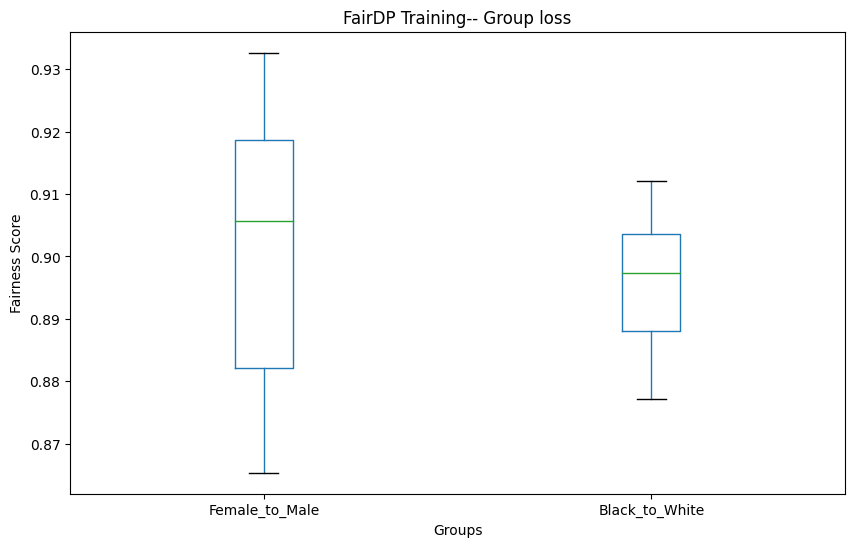

In [61]:
plt.figure(figsize=(10, 6))
fairDP_train_df.drop("State", axis=1).boxplot()
plt.title("FairDP Training-- Group loss")
plt.ylabel("Fairness Score")
plt.xlabel("Groups")
plt.grid(False)
plt.show()